### Diffusion Model using U-Net with Time Embeddings

This is an implementation of a U-Net architecture conditioned on time embeddings for diffusion tasks. The model takes in noisy data and predicts the vector field at a given time step.

In [1]:
import math
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

### Sinusoidal Time Embeddings and U-Net Model

We implement sinusoidal time embeddings and a U-Net architecture that incorporates these embeddings to condition the model on time.

Note that the model input is noise and the time embedding, and the output is the predicted vector field at that time step.

In [2]:
# ----------------------------
# Utilities: time embedding
# ----------------------------
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):  # t shape: (B,)
        device = t.device
        half = self.dim // 2
        emb = torch.exp(torch.arange(half, device=device) * -(math.log(10000) / (half - 1)))
        emb = t[:, None] * emb[None, :]  # (B, half)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        if self.dim % 2 == 1:  # odd dim
            emb = F.pad(emb, (0, 1))
        return emb  # (B, dim)

# ----------------------------
# Small U-Net for 1x28x28 images
# ----------------------------
def conv_block(in_c, out_c, time_emb_dim=None):
    layers = [
        nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
        nn.GroupNorm(8, out_c),
        nn.SiLU(),
    ]
    if time_emb_dim is not None:
        # add time-conditioned bias after conv
        layers.append(TimeCondition(out_c, time_emb_dim))
    return nn.Sequential(*layers)

class TimeCondition(nn.Module):
    def __init__(self, channels, time_emb_dim):
        super().__init__()
        self.proj = nn.Linear(time_emb_dim, channels)

    def forward(self, x):
        # this module will never be used stand-alone in my conv_block chain
        raise NotImplementedError("TimeCondition is used in UNet forward directly.")

class UNetSimple(nn.Module):
    def __init__(self, time_emb_dim=128):
        super().__init__()
        self.time_emb = SinusoidalPosEmb(time_emb_dim)
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim * 2),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 2, time_emb_dim),
        )

        # Encoder
        self.inc = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.GroupNorm(8, 32),
            nn.SiLU(),
        )
        self.down1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 28->14
            nn.GroupNorm(8, 64),
            nn.SiLU(),
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 14->7
            nn.GroupNorm(8, 128),
            nn.SiLU(),
        )

        # Bottleneck
        self.mid = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.GroupNorm(8, 128),
            nn.SiLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.GroupNorm(8, 128),
            nn.SiLU(),
        )

        # Decoder
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 7->14
            nn.GroupNorm(8, 64),
            nn.SiLU(),
        )
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(128, 32, kernel_size=4, stride=2, padding=1),  # 14->28
            nn.GroupNorm(8, 32),
            nn.SiLU(),
        )

        self.outc = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.GroupNorm(8, 32),
            nn.SiLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
        )

        # small MLP to inject time into features at each stage
        self.time_proj0 = nn.Linear(time_emb_dim, 32)
        self.time_proj1 = nn.Linear(time_emb_dim, 64)
        self.time_proj2 = nn.Linear(time_emb_dim, 128)
        self.time_proj_mid = nn.Linear(time_emb_dim, 128)
        self.time_proj_up1 = nn.Linear(time_emb_dim, 128)
        self.time_proj_up2 = nn.Linear(time_emb_dim, 64)

    def forward(self, x, t):
        """
        x: (B, 1, 28, 28)
        t: (B,) in [0,1]
        output: predicted velocity v(x_t, t) same shape as x
        """
        B = x.shape[0]
        te = self.time_emb(t)         # (B, time_dim)
        te = self.time_mlp(te)        # (B, time_dim)

        # encode
        e0 = self.inc(x)              # (B,32,28,28)
        e0 = e0 + self.time_proj0(te)[:, :, None, None]
        e1 = self.down1(e0)           # (B,64,14,14)
        e1 = e1 + self.time_proj1(te)[:, :, None, None]
        e2 = self.down2(e1)           # (B,128,7,7)
        e2 = e2 + self.time_proj2(te)[:, :, None, None]

        # mid
        m = self.mid(e2)
        m = m + self.time_proj_mid(te)[:, :, None, None]
        # decode
        d2 = self.up2(m)              # (B,64,14,14)
        d2 = torch.cat([d2, e1], dim=1)  # (B,128,14,14)

        d2 = d2 + self.time_proj_up1(te)[:, :, None, None]

        d1 = self.up1(d2)             # (B,32,28,28)
        d1 = torch.cat([d1, e0], dim=1)  # (B,64,28,28)
        d1 = d1 + self.time_proj_up2(te)[:, :, None, None]

        out = self.outc(d1)           # (B,1,28,28)  => velocity
        return out



### Diffusion Sampler using U-Net with Time Embeddings



In [6]:
# -------------------------------------
# Diffusion functions
# -------------------------------------
def make_beta_schedule(T, start=1e-4, end=0.02):
    return torch.linspace(start, end, T)


class DDPM:
    def __init__(self, model, T=1000, device="cuda"):
        self.model = model
        self.T = T
        self.device = device

        betas = make_beta_schedule(T).to(device)
        self.betas = betas
        self.alphas = 1.0 - betas
        self.alpha_cum = torch.cumprod(self.alphas, dim=0)

        self.sqrt_alpha_cum = torch.sqrt(self.alpha_cum)
        self.sqrt_1m_alpha_cum = torch.sqrt(1 - self.alpha_cum)

    # q(x_t | x_0)
    def q_sample(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        return (
            extract(self.sqrt_alpha_cum, t, x0.shape) * x0 +
            extract(self.sqrt_1m_alpha_cum, t, x0.shape) * noise
        )

    # sampling reverse
    @torch.no_grad()
    def sample(self, n=64):
        x = torch.randn(n, 1, 28, 28, device=self.device)

        for i in reversed(range(self.T)):
            t = torch.full((n,), i, device=self.device, dtype=torch.long)
            eps = self.model(x, t / self.T)

            beta = self.betas[i]
            alpha = self.alphas[i]
            alpha_cum = self.alpha_cum[i]

            # DDPM reverse step
            if i > 0:
                noise = torch.randn_like(x)
            else:
                noise = 0

            x = (1 / torch.sqrt(alpha)) * (x - beta / torch.sqrt(1 - alpha_cum) * eps) + torch.sqrt(beta) * noise

        return x


# extract a[t] -> reshape to x shape
def extract(a, t, x_shape):
    return a[t].view(-1, 1, 1, 1)


# -------------------------------------
# Training loop
# -------------------------------------
def train_ddpm(
    device="cuda",
    epochs=10,
    batch_size=128,
    lr=2e-4,
    T=1000,
    model_save_dir="models_ddpm",
    sample_dir="samples_ddpm",
):
    os.makedirs(model_save_dir, exist_ok=True)
    os.makedirs(sample_dir, exist_ok=True)

    # MNIST [-1, 1]
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = datasets.MNIST(root="~/data", train=True, download=True, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    model = UNetSimple().to(device)
    ddpm = DDPM(model, T=T, device=device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()

    for ep in range(1, epochs + 1):
        model.train()
        total_loss = 0

        for x0, _ in loader:
            x0 = x0.to(device)

            # sample t uniformly
            b = x0.shape[0]
            t = torch.randint(0, T, (b,), device=device).long()
            t_float = t.float() / T

            noise = torch.randn_like(x0)
            xt = ddpm.q_sample(x0, t, noise)

            # network predicts noise
            pred_noise = model(xt, t_float)
            loss = mse(pred_noise, noise)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()

        print(f"Epoch {ep}: loss={total_loss/len(loader):.6f}")

        # sample and save
        model.eval()
        with torch.no_grad():
            samples = ddpm.sample(n=16)
            samples = (samples.clamp(-1, 1) + 1) / 2  # to [0,1]
            image_path = os.path.join(sample_dir, f"ep{ep}.png")
            utils.save_image(samples, image_path, nrow=4)
            print(f"Saved sample images to {image_path}")

        torch.save(model.state_dict(), os.path.join(model_save_dir, f"ddpm_ep{ep}.pt"))
        checkpoint_path = os.path.join(model_save_dir, f"ddpm_ep{ep}.pt")
        print(f"Saved samples and checkpoint for epoch {ep} at {checkpoint_path}")



In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)
model = UNetSimple(time_emb_dim=128).to(device)
#print(model)
data = torch.randn(1, 1, 28, 28).to(device)
output = model(data, torch.tensor([0.5], device=device))
print("Output shape:", output.shape)
# number of parameters
num_params = sum(p.numel() for p in model.parameters())
# in Millions
print(f"Number of parameters in the model: {num_params / 1e6:.2f} Million")

Using device: cuda
Output shape: torch.Size([1, 1, 28, 28])
Number of parameters in the model: 0.81 Million


In [8]:
train_ddpm(
        device="cuda" if torch.cuda.is_available() else "cpu",
        epochs=10,
        batch_size=64,
        lr=2e-4,
        T=1000,
    )

Epoch 1: loss=0.074668
Saved sample images to samples_ddpm/ep1.png
Saved samples and checkpoint for epoch 1 at models_ddpm/ddpm_ep1.pt
Epoch 2: loss=0.040363
Saved sample images to samples_ddpm/ep2.png
Saved samples and checkpoint for epoch 2 at models_ddpm/ddpm_ep2.pt
Epoch 3: loss=0.034769
Saved sample images to samples_ddpm/ep3.png
Saved samples and checkpoint for epoch 3 at models_ddpm/ddpm_ep3.pt
Epoch 4: loss=0.032339
Saved sample images to samples_ddpm/ep4.png
Saved samples and checkpoint for epoch 4 at models_ddpm/ddpm_ep4.pt
Epoch 5: loss=0.030365
Saved sample images to samples_ddpm/ep5.png
Saved samples and checkpoint for epoch 5 at models_ddpm/ddpm_ep5.pt
Epoch 6: loss=0.029320
Saved sample images to samples_ddpm/ep6.png
Saved samples and checkpoint for epoch 6 at models_ddpm/ddpm_ep6.pt
Epoch 7: loss=0.028639
Saved sample images to samples_ddpm/ep7.png
Saved samples and checkpoint for epoch 7 at models_ddpm/ddpm_ep7.pt
Epoch 8: loss=0.028083
Saved sample images to samples_d

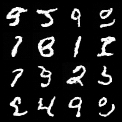

In [10]:
# display samples in notebook
from IPython.display import Image, display
display(Image(filename='samples_ddpm/ep10.png'))

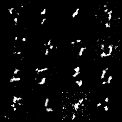

In [11]:
display(Image(filename='samples_ddpm/ep1.png'))